In [ ]:
import yfinance
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [60]:
def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

<h2>Data Collection</h2>

Financial data of different sectors was downloaded with web scraping and saved. 

Later, using the yfinance library, monthly open stock data of companies from the Financials, Healthcare and Technology sectors were downloaded and saved.

In [61]:
sectors=fetch_sectors_names()
indusrty=fetch_industry_names()

In [62]:
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1312,12.09T,0.17%,15.93,20.17%,0.28%,36.75%
1,Healthcare,1191,"7,973.87B",0.50%,63.84,2.94%,-0.93%,10.67%
2,Technology,805,22.25T,0.49%,48.20,14.32%,5.35%,50.76%
3,Industrials,687,"5,912.68B",1.19%,30.18,7.04%,-0.11%,25.16%
4,Consumer Discretionary,573,"8,941.80B",0.76%,30.17,6.46%,0.42%,36.89%
5,Materials,272,"2,061.34B",1.71%,28.37,6.24%,-0.62%,15.96%
6,Real Estate,264,"1,695.09B",3.84%,50.51,9.30%,-0.33%,19.36%
7,Communication Services,254,"7,019.84B",1.37%,31.18,11.68%,0.45%,40.62%
8,Energy,254,"3,652.96B",3.15%,13.62,8.07%,0.12%,12.99%
9,Consumer Staples,246,"4,297.51B",1.51%,26.14,5.64%,-0.95%,31.02%


In [5]:
fetch_data(sectors='energy').to_csv('./data/stock_sectors/energy.csv')
fetch_data(sectors='financials').to_csv('./data/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('./data/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('./data/stock_sectors/technology.csv')
fetch_data(sectors='utilities').to_csv('./data/stock_sectors/utilities.csv')
fetch_data(sectors='real-estate').to_csv('./data/stock_sectors/real-estate.csv')
fetch_data(sectors='materials').to_csv('./data/stock_sectors/materials.csv')
fetch_data(sectors='technology').to_csv('./data/stock_sectors/technology.csv')
fetch_data(sectors='industrials').to_csv('./data/stock_sectors/industrials.csv')
fetch_data(sectors='consumer-staples').to_csv('./data/stock_sectors/consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv('./data/stock_sectors/consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv('./data/stock_sectors/communication-services.csv')

In [23]:
financials = pd.read_csv("./data/stock_sectors/financials.csv")
healthcare = pd.read_csv("./data/stock_sectors/healthcare.csv")
technology = pd.read_csv("./data/stock_sectors/technology.csv")

<h3>Downloading and Saving Technology Companies Monthly Stock Data</h3>

In [ ]:
technology_ticker_list = technology["Symbol"].astype(str).tolist()
technology_data = yfinance.download(technology_ticker_list, start="2005-01-01")
technology_data_open = technology_data[["Open"]]
technology_data_open.columns = [
    "_".join(col) for col in technology_data_open.columns
]  # MultiIndex to SingleIndex
technology_data_monthly_mom = (
    technology_data["Open"].resample("ME").last().pct_change() + 1
)

[*********************100%***********************]  769 of 769 completed

1 Failed download:
['ULY']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
C:\Users\Beyza\AppData\Local\Temp\ipykernel_5484\1513293336.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  technology_data["Open"].resample("ME").last().pct_change() + 1


In [26]:
technology_data_monthly_mom.to_csv("./data/data_monthly/technology_data_monthly_mom.csv")

<h3>Downloading and Saving Healthcare Companies Monthly Stock Data</h3>

In [ ]:
healthcare_ticker_list = healthcare["Symbol"].tolist()
healthcare_data = yfinance.download(healthcare_ticker_list, start="2005-01-01")
healthcare_data_open = healthcare_data[["Open"]]
healthcare_data_open.columns = [
    "_".join(col) for col in healthcare_data_open.columns
]  # MultiIndex to SingleIndex
healthcare_data_monthly_mom = (
    healthcare_data["Open"].resample("ME").last().pct_change() + 1
)

[*********************100%***********************]  1163 of 1163 completed

410 Failed downloads:
['BIO.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2005-01-01 -> 2025-02-12)')
['BCDA', 'IRON', 'SLN', 'JUNS', 'NGNE', 'MNDR', 'SPRY', 'RDY', 'WVE', 'AZTR', 'INM', 'SYBX', 'ERNA', 'DVAX', 'THTX', 'MURA', 'DXR', 'MCK', 'AMRX', 'CSBR', 'FORA', 'HRTX', 'ADTX', 'AHCO', 'MPLN', 'SNYR', 'RGEN', 'SMTI', 'IKNA', 'PALI', 'NRXS', 'KRMD', 'LRMR', 'MEIP', 'CYTH', 'ATNM', 'SSY', 'AVXL', 'OGI', 'LSTA', 'DCTH', 'STRM', 'GLYC', 'KURA', 'CTSO', 'CHRO', 'FENC', 'AVAH', 'APDN', 'DYAI', 'POCI', 'DCGO', 'CODX', 'PRTG', 'LMAT', 'ONVO', 'LYRA', 'RGLS', 'LH', 'ANTX', 'DVA', 'CPIX', 'OFIX', 'VERO', 'ENZ', 'BIO', 'GHRS', 'APYX', 'IMCR', 'MRUS', 'SINT', 'JANX', 'ESPR', 'XBIT', 'INTS', 'ZYBT', 'CLDX', 'ARQT', 'ARCT', 'ALUR', 'MBIO', 'BCYC', 'DH', 'INBX', 'KPRX', 'RVPH', 'SBFM', 'JAGX', 'AXDX', 'GANX', 'NXGL', 'VALN', 'CELZ', 'TNYA', 'CGEN', 'IXHL', 'IFRX', 'SENS', 'AFMD', 'BLTE', 

In [5]:
healthcare_data_monthly_mom.to_csv("./data/data_monthly/healthcare_data_monthly_mom.csv")

<h3>Downloading and Saving Financials Companies Monthly Stock Data</h3>

In [ ]:
financials_ticker_list = financials["Symbol"].tolist()
financials_data = yfinance.download(financials_ticker_list, start="2005-01-01")
financials_data_open = financials_data[["Open"]]
financials_data_open.columns = [
    "_".join(col) for col in financials_data_open.columns
]  # MultiIndex to SingleIndex
financials_data_monthly_mom = (
    financials_data["Open"].resample("ME").last().pct_change() + 1
)

[*********************100%***********************]  880 of 880 completed

164 Failed downloads:
['CRD.B', 'JACS.RT', 'COLA', 'KFII', 'CRD.A', 'RIBB', 'DMAA', 'SVCC', 'AGM.A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['TDAC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2005-01-01 -> 2025-02-12)')
['SWKH', 'AROW', 'GNTY', 'MARA', 'BAFN', 'SSSS', 'DFS', 'BANC', 'AAME', 'SLQT', 'STEP', 'OWL', 'PSBD', 'BACQ', 'FIHL', 'SMBK', 'EMCG', 'TW', 'CASH', 'NAVI', 'CFR', 'EG', 'UBS', 'JXN', 'BYFC', 'BBVA', 'OSBC', 'BWB', 'BCG', 'TRV', 'NCTY', 'ALCY', 'AMTD', 'GEG', 'AQU', 'RMBI', 'ARCC', 'VRTS', 'BOKF', 'AB', 'ALDF', 'TPVG', 'KEY', 'FBLA', 'EBC', 'MOFG', 'SPHA', 'MA', 'GREE', 'IFS', 'RYAN', 'WMPN', 'PLMK', 'GAIN', 'SII', 'AJG', 'BLFY', 'CION', 'NTB', 'PNNT', 'FMBH', 'HLNE', 'CB', 'FSEA', 'ATMV', 'ACIC', 'BMRC', 'KRNY', 'CMA', 'CHCO', 'MBIN', 'PRK', 'NWFL', 'AVAL', 'SKWD', 'OACC', 'FSHP', 'ASPC', 'GS', 'KMPR', 'HRTG', 'NCPL', 'PEBK', 'GLAC'

In [29]:
financials_data_monthly_mom.to_csv("./data/data_monthly/financials_data_monthly_mom.csv")

<h2>Data Preprocessing</h2>

turned date into a column, turned ticker names into seperate rows for each company, checked and cleaned the emty values.

Repeated listed processes for all three sectors(financials, healthcare, technology)

In [4]:
f_data = pd.read_csv("./data/data_monthly/financials_data_monthly_mom.csv")
h_data = pd.read_csv("./data/data_monthly/healthcare_data_monthly_mom.csv")
t_data = pd.read_csv("./data/data_monthly/technology_data_monthly_mom.csv")

In [8]:
# turn date into a column
f_data = f_data.reset_index(drop="True")

# turn ticker names into rows
f_data = f_data.melt(id_vars=["Date"], var_name="Ticker", value_name="Open")
f_data

,Date,Ticker,Open
0,2005-01-31,AACT,NaN
1,2005-02-28,AACT,NaN
2,2005-03-31,AACT,NaN
3,2005-04-30,AACT,NaN
4,2005-05-31,AACT,NaN
...,...,...,...
212955,2024-10-31,ZION,1.128908
212956,2024-11-30,ZION,1.169964
212957,2024-12-31,ZION,0.889941
212958,2025-01-31,ZION,1.069725


In [9]:
# check for empty values
print(f_data.isna().sum())

Date           0
Ticker         0
Open      103380
dtype: int64


In [10]:
# delete rows that contain empty values
f_data = f_data.dropna()

# check if empty values are deleted
print(f_data.isna().sum())
f_data

Date      0
Ticker    0
Open      0
dtype: int64


,Date,Ticker,Open
222,2023-07-31,AACT,1.000000
223,2023-08-31,AACT,1.005900
224,2023-09-30,AACT,1.002933
225,2023-10-31,AACT,1.002924
226,2023-11-30,AACT,1.007775
...,...,...,...
212955,2024-10-31,ZION,1.128908
212956,2024-11-30,ZION,1.169964
212957,2024-12-31,ZION,0.889941
212958,2025-01-31,ZION,1.069725


In [11]:
# turn date into a column
h_data = h_data.reset_index(drop=True)

# turn ticker names into rows
h_data = h_data.melt(id_vars=["Date"], var_name="Ticker", value_name="Open")
h_data

,Date,Ticker,Open
0,2005-01-31,A,NaN
1,2005-02-28,A,1.073382
2,2005-03-31,A,0.946072
3,2005-04-30,A,0.933573
4,2005-05-31,A,1.141827
...,...,...,...
281441,2024-10-31,ZYXI,NaN
281442,2024-11-30,ZYXI,NaN
281443,2024-12-31,ZYXI,NaN
281444,2025-01-31,ZYXI,NaN


In [7]:
# check empty values
print(h_data.isna().sum())

Date           0
Ticker         0
Open      194045
dtype: int64


In [12]:
# delete empty values
h_data = h_data.dropna()

# check if empty values are deleted
print(h_data.isna().sum())
h_data

Date      0
Ticker    0
Open      0
dtype: int64


,Date,Ticker,Open
1,2005-02-28,A,1.073382
2,2005-03-31,A,0.946072
3,2005-04-30,A,0.933573
4,2005-05-31,A,1.141827
5,2005-06-30,A,0.971790
...,...,...,...
281199,2024-10-31,ZYME,1.118548
281200,2024-11-30,ZYME,1.042538
281201,2024-12-31,ZYME,1.011065
281202,2025-01-31,ZYME,1.010260


In [16]:
# turn date into a column
t_data = t_data.reset_index(drop=True)

# turn ticker names into rows
t_data = t_data.melt(id_vars=["Date"], var_name="Ticker", value_name="Open")
t_data

,Date,Ticker,Open
0,2013-10-31,Ticker,AAOI
1,2013-11-30,Ticker,AAOI
2,2013-12-31,Ticker,AAOI
3,2014-01-31,Ticker,AAOI
4,2014-02-28,Ticker,AAOI
...,...,...,...
209089,2024-10-31,Close,1.150637
209090,2024-11-30,Close,1.001007
209091,2024-12-31,Close,0.997988
209092,2025-01-31,Close,1.007056


In [17]:
# delete empty values
t_data = t_data.dropna()

# check if empty values are deleted
print(t_data.isna().sum())
t_data

Date      0
Ticker    0
Open      0
dtype: int64


,Date,Ticker,Open
0,2013-10-31,Ticker,AAOI
1,2013-11-30,Ticker,AAOI
2,2013-12-31,Ticker,AAOI
3,2014-01-31,Ticker,AAOI
4,2014-02-28,Ticker,AAOI
...,...,...,...
209089,2024-10-31,Close,1.150637
209090,2024-11-30,Close,1.001007
209091,2024-12-31,Close,0.997988
209092,2025-01-31,Close,1.007056


<h3>Feature Engineering With Tsfresh</h3>

tsfresh (Time Series Feature Extraction based on Scalable Hypothesis tests) is a Python library designed to automatically extract meaningful features from time-series data.

It applies statistical and signal processing techniques to generate a wide range of features, such as trend indicators, statistical moments, and frequency domain properties. 

These extracted features help improve machine learning models by capturing hidden patterns in time-dependent data.

In [ ]:
# extracting features for technology
t_data_features = extract_features(t_data, column_id='Ticker', column_sort='Date', 
                                       default_fc_parameters=ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


In [23]:
t_data_features.columns

Index(['Close__variance_larger_than_standard_deviation',
       'Close__has_duplicate_max', 'Close__has_duplicate_min',
       'Close__has_duplicate', 'Close__sum_values', 'Close__abs_energy',
       'Close__mean_abs_change', 'Close__mean_change',
       'Close__mean_second_derivative_central', 'Close__median',
       ...
       'Close__fourier_entropy__bins_5', 'Close__fourier_entropy__bins_10',
       'Close__fourier_entropy__bins_100',
       'Close__permutation_entropy__dimension_3__tau_1',
       'Close__permutation_entropy__dimension_4__tau_1',
       'Close__permutation_entropy__dimension_5__tau_1',
       'Close__permutation_entropy__dimension_6__tau_1',
       'Close__permutation_entropy__dimension_7__tau_1',
       'Close__query_similarity_count__query_None__threshold_0.0',
       'Close__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

In [24]:
t_data_features.head()

,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
AAOI,0.0,0.0,0.0,0.0,142.806700,161.413989,0.307223,-0.002124,1.608148e-03,0.969529,...,1.066016,1.707891,3.530521,1.787862,3.072864,4.237414,4.735771,4.854033,NaN,1.991285
AAPL,0.0,0.0,0.0,0.0,247.449789,256.148636,0.100585,-0.001090,4.299758e-04,1.026278,...,1.237296,1.888322,3.763590,1.787595,3.153237,4.516633,5.242055,5.441888,NaN,1.218797
ACIW,0.0,0.0,0.0,1.0,244.049036,249.239145,0.100859,-0.000671,7.578920e-08,1.010515,...,0.603018,1.237320,3.263213,1.787939,3.144964,4.514615,5.208250,5.418292,NaN,1.257802
ACLS,0.0,0.0,0.0,1.0,245.583540,257.096980,0.174989,-0.001496,3.876433e-04,1.009132,...,0.986858,1.616381,3.661314,1.788676,3.151260,4.529663,5.255243,5.441888,NaN,1.451027
ACMR,0.0,0.0,0.0,0.0,91.740699,102.322273,0.290364,0.003911,-3.113971e-03,1.002016,...,1.166769,1.726158,3.252129,1.787431,3.113037,4.082584,4.356001,4.394449,NaN,1.647787


In [ ]:
# adding a column indicating the sector of the features
t_data_features.insert(0, "Sector", "T")

t_data_features

,Sector,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
AAOI,T,0.0,0.0,0.0,0.0,142.806700,161.413989,0.307223,-0.002124,1.608148e-03,...,1.066016,1.707891,3.530521,1.787862,3.072864,4.237414,4.735771,4.854033,NaN,1.991285
AAPL,T,0.0,0.0,0.0,0.0,247.449789,256.148636,0.100585,-0.001090,4.299758e-04,...,1.237296,1.888322,3.763590,1.787595,3.153237,4.516633,5.242055,5.441888,NaN,1.218797
ACIW,T,0.0,0.0,0.0,1.0,244.049036,249.239145,0.100859,-0.000671,7.578920e-08,...,0.603018,1.237320,3.263213,1.787939,3.144964,4.514615,5.208250,5.418292,NaN,1.257802
ACLS,T,0.0,0.0,0.0,1.0,245.583540,257.096980,0.174989,-0.001496,3.876433e-04,...,0.986858,1.616381,3.661314,1.788676,3.151260,4.529663,5.255243,5.441888,NaN,1.451027
ACMR,T,0.0,0.0,0.0,0.0,91.740699,102.322273,0.290364,0.003911,-3.113971e-03,...,1.166769,1.726158,3.252129,1.787431,3.113037,4.082584,4.356001,4.394449,NaN,1.647787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZETA,T,0.0,0.0,0.0,0.0,45.661179,48.862854,0.187034,0.007768,-3.023477e-03,...,1.446653,1.846997,2.871650,1.753495,2.709623,3.268405,3.556924,3.601105,NaN,1.332029
ZI,T,0.0,0.0,0.0,0.0,54.961536,55.001659,0.174385,0.002958,-1.604883e-03,...,1.141138,1.674756,2.853177,1.742263,2.917109,3.764627,3.931826,3.912023,NaN,1.213355
ZM,T,0.0,0.0,0.0,0.0,70.990085,73.785913,0.154942,-0.003112,-1.010331e-03,...,0.799263,1.326171,2.799318,1.763461,2.989099,3.681719,4.067749,4.137222,NaN,1.350458
ZS,T,0.0,0.0,0.0,0.0,85.961359,90.942231,0.162921,-0.000290,2.427369e-04,...,1.207298,1.765547,3.269556,1.781566,3.091318,4.009542,4.303390,4.343805,NaN,1.345846


In [ ]:
#save the features
t_data_features.to_csv("./data/training/t_data_features.csv", index=False)

In [ ]:
#extracting features for healthcare
h_data_features = extract_features(h_data, column_id='Ticker', column_sort='Date', 
                                       default_fc_parameters=ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


In [29]:
h_data_features.columns

Index(['Open__variance_larger_than_standard_deviation',
       'Open__has_duplicate_max', 'Open__has_duplicate_min',
       'Open__has_duplicate', 'Open__sum_values', 'Open__abs_energy',
       'Open__mean_abs_change', 'Open__mean_change',
       'Open__mean_second_derivative_central', 'Open__median',
       ...
       'Open__fourier_entropy__bins_5', 'Open__fourier_entropy__bins_10',
       'Open__fourier_entropy__bins_100',
       'Open__permutation_entropy__dimension_3__tau_1',
       'Open__permutation_entropy__dimension_4__tau_1',
       'Open__permutation_entropy__dimension_5__tau_1',
       'Open__permutation_entropy__dimension_6__tau_1',
       'Open__permutation_entropy__dimension_7__tau_1',
       'Open__query_similarity_count__query_None__threshold_0.0',
       'Open__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

In [30]:
h_data_features.head()

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,0.0,0.0,244.222366,249.213158,0.092531,-0.000642,-0.000153,1.014059,...,1.150754,1.769075,3.619506,1.786000,3.112653,4.445591,5.197648,5.394695,NaN,1.228913
AADI,0.0,0.0,0.0,0.0,83.329676,87.834011,0.262562,-0.000795,0.001310,0.990939,...,1.241813,1.908651,3.382230,1.781448,3.077576,4.063570,4.316804,4.356709,NaN,1.491290
AAPG,0.0,0.0,0.0,0.0,1.002114,1.004233,NaN,NaN,NaN,1.002114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABCL,0.0,0.0,0.0,0.0,48.121088,47.647006,0.198444,-0.007497,0.002487,0.968201,...,1.396402,2.001916,3.258097,1.784218,3.016464,3.647820,3.775856,3.784190,NaN,1.212711
ABOS,0.0,0.0,0.0,0.0,42.295759,45.346452,0.346805,-0.010592,0.004953,0.925065,...,1.324974,1.822436,2.775976,1.766038,2.943407,3.507961,3.637586,3.610918,NaN,1.524239


In [ ]:
# adding a column indicating the sector of the features
h_data_features.insert(0, "Sector", "H")

h_data_features

,Sector,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
A,H,0.0,0.0,0.0,0.0,244.222366,249.213158,0.092531,-0.000642,-0.000153,...,1.150754,1.769075,3.619506,1.786000,3.112653,4.445591,5.197648,5.394695,NaN,1.228913
AADI,H,0.0,0.0,0.0,0.0,83.329676,87.834011,0.262562,-0.000795,0.001310,...,1.241813,1.908651,3.382230,1.781448,3.077576,4.063570,4.316804,4.356709,NaN,1.491290
AAPG,H,0.0,0.0,0.0,0.0,1.002114,1.004233,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABCL,H,0.0,0.0,0.0,0.0,48.121088,47.647006,0.198444,-0.007497,0.002487,...,1.396402,2.001916,3.258097,1.784218,3.016464,3.647820,3.775856,3.784190,NaN,1.212711
ABOS,H,0.0,0.0,0.0,0.0,42.295759,45.346452,0.346805,-0.010592,0.004953,...,1.324974,1.822436,2.775976,1.766038,2.943407,3.507961,3.637586,3.610918,NaN,1.524239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIMV,H,0.0,0.0,0.0,0.0,35.823600,37.558668,0.222879,0.009053,-0.007755,...,1.093770,1.480112,2.798513,1.788225,2.918680,3.379093,3.433987,3.401197,NaN,1.309545
ZOM,H,0.0,0.0,0.0,1.0,88.050248,102.433291,0.267730,0.002084,-0.001351,...,1.304910,1.935472,3.425724,1.783047,3.106382,4.111894,4.372907,4.394449,NaN,1.982690
ZTS,H,0.0,0.0,0.0,0.0,146.042373,148.658828,0.069899,-0.000033,-0.000252,...,1.273449,1.885326,3.688617,1.786431,3.108212,4.239516,4.721269,4.866980,NaN,1.131454
ZURA,H,0.0,0.0,0.0,0.0,21.885612,23.443384,0.389003,0.011109,-0.000257,...,1.473502,1.820076,2.484907,1.753308,2.484367,2.944439,2.890372,2.833213,NaN,1.335317


In [ ]:
# save the features
h_data_features.to_csv("./data/training/h_data_features.csv", index=False)

In [ ]:
# extracting features for financials
f_data_features = extract_features(f_data, column_id='Ticker', column_sort='Date', 

                                       default_fc_parameters=ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 20/20 [01:03<00:00,  3.19s/it]


In [34]:
f_data_features.columns

Index(['Open__variance_larger_than_standard_deviation',
       'Open__has_duplicate_max', 'Open__has_duplicate_min',
       'Open__has_duplicate', 'Open__sum_values', 'Open__abs_energy',
       'Open__mean_abs_change', 'Open__mean_change',
       'Open__mean_second_derivative_central', 'Open__median',
       ...
       'Open__fourier_entropy__bins_5', 'Open__fourier_entropy__bins_10',
       'Open__fourier_entropy__bins_100',
       'Open__permutation_entropy__dimension_3__tau_1',
       'Open__permutation_entropy__dimension_4__tau_1',
       'Open__permutation_entropy__dimension_5__tau_1',
       'Open__permutation_entropy__dimension_6__tau_1',
       'Open__permutation_entropy__dimension_7__tau_1',
       'Open__query_similarity_count__query_None__threshold_0.0',
       'Open__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

In [35]:
f_data_features.head()

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
AACT,0.0,0.0,0.0,1.0,20.083263,20.167080,0.004131,0.000143,-0.000215,1.004184,...,1.342113,1.720193,2.397895,1.599971,2.394700,2.772589,2.708050,2.639057,NaN,1.007459
AAM,0.0,0.0,0.0,0.0,5.014888,5.029834,0.001745,0.000243,-0.000663,1.001994,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,NaN,NaN,NaN,NaN
AAMI,0.0,0.0,0.0,0.0,125.434508,128.470793,0.126364,-0.000320,0.000382,1.007235,...,1.363936,1.997441,3.752444,1.786189,3.044054,4.211172,4.623283,4.723692,NaN,1.258428
ABCB,0.0,0.0,0.0,0.0,244.052552,249.781002,0.115266,-0.000333,0.000103,1.008389,...,0.950069,1.546614,3.508705,1.776915,3.068427,4.367493,5.139200,5.418292,NaN,1.263715
ABL,0.0,0.0,0.0,0.0,53.140447,54.156447,0.086228,-0.000744,-0.000982,1.002024,...,1.568690,2.210813,3.193148,1.773515,2.979266,3.693778,3.871201,3.850148,NaN,1.214115


In [ ]:
# adding a column indicating the sector of the features
f_data_features.insert(0, "Sector", "F")

f_data_features

,Sector,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
AACT,F,0.0,0.0,0.0,1.0,20.083263,20.167080,0.004131,0.000143,-0.000215,...,1.342113,1.720193,2.397895,1.599971,2.394700,2.772589,2.708050,2.639057,NaN,1.007459
AAM,F,0.0,0.0,0.0,0.0,5.014888,5.029834,0.001745,0.000243,-0.000663,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,NaN,NaN,NaN,NaN
AAMI,F,0.0,0.0,0.0,0.0,125.434508,128.470793,0.126364,-0.000320,0.000382,...,1.363936,1.997441,3.752444,1.786189,3.044054,4.211172,4.623283,4.723692,NaN,1.258428
ABCB,F,0.0,0.0,0.0,0.0,244.052552,249.781002,0.115266,-0.000333,0.000103,...,0.950069,1.546614,3.508705,1.776915,3.068427,4.367493,5.139200,5.418292,NaN,1.263715
ABL,F,0.0,0.0,0.0,0.0,53.140447,54.156447,0.086228,-0.000744,-0.000982,...,1.568690,2.210813,3.193148,1.773515,2.979266,3.693778,3.871201,3.850148,NaN,1.214115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOTA,F,0.0,0.0,0.0,1.0,32.172466,32.352713,0.016662,-0.000603,-0.000866,...,1.364719,1.921336,2.670120,1.748067,2.721485,3.233183,3.295837,3.258097,NaN,1.025641
YRD,F,0.0,0.0,0.0,0.0,112.256834,121.093365,0.238837,0.003487,-0.001453,...,1.319382,1.882271,3.414094,1.771397,3.032581,4.029838,4.530152,4.631061,NaN,1.714045
ZBAI,F,0.0,0.0,0.0,0.0,70.440231,84.390841,0.273172,0.001042,-0.002596,...,1.252208,1.870829,3.074806,1.764110,2.913802,3.792896,4.093901,4.143135,NaN,1.785984
ZBAO,F,0.0,0.0,0.0,0.0,9.276627,8.829165,0.150809,-0.028634,0.026717,...,1.242453,1.560710,1.791759,1.732868,1.945910,1.791759,1.609438,1.386294,NaN,0.995099


In [ ]:
# save the features
f_data_features.to_csv("./data/training/f_data_features.csv", index=False)

In [ ]:
# read the features for all  three sectors
f_features = pd.read_csv("./data/training/f_data_features.csv")
h_features = pd.read_csv("./data/training/h_data_features.csv")
t_features = pd.read_csv("./data/training/t_data_features.csv")

In [ ]:
# combine the features into a single dataset
df_combined = pd.concat([f_features, h_features, t_features])
df_combined

,Sector,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
0,F,0.0,0.0,0.0,1.0,20.083263,20.167080,0.004131,0.000143,-0.000215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,0.0,0.0,0.0,0.0,5.014888,5.029834,0.001745,0.000243,-0.000663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,0.0,0.0,0.0,0.0,125.434508,128.470793,0.126364,-0.000320,0.000382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,0.0,0.0,0.0,0.0,244.052552,249.781002,0.115266,-0.000333,0.000103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,0.0,0.0,0.0,0.0,53.140447,54.156447,0.086228,-0.000744,-0.000982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.446653,1.846997,2.871650,1.753495,2.709623,3.268405,3.556924,3.601105,NaN,1.332029
764,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.141138,1.674756,2.853177,1.742263,2.917109,3.764627,3.931826,3.912023,NaN,1.213355
765,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.799263,1.326171,2.799318,1.763461,2.989099,3.681719,4.067749,4.137222,NaN,1.350458
766,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.207298,1.765547,3.269556,1.781566,3.091318,4.009542,4.303390,4.343805,NaN,1.345846


In [ ]:
# save the combined dataset
df_combined.to_csv("./data/training/df_combined.csv", index=False)

In [ ]:
# read the combined dataset
df = pd.read_csv("./data/training/df_combined.csv")
df

,Sector,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
0,F,0.0,0.0,0.0,1.0,20.083263,20.167080,0.004131,0.000143,-0.000215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,0.0,0.0,0.0,0.0,5.014888,5.029834,0.001745,0.000243,-0.000663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,0.0,0.0,0.0,0.0,125.434508,128.470793,0.126364,-0.000320,0.000382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,0.0,0.0,0.0,0.0,244.052552,249.781002,0.115266,-0.000333,0.000103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,0.0,0.0,0.0,0.0,53.140447,54.156447,0.086228,-0.000744,-0.000982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.446653,1.846997,2.871650,1.753495,2.709623,3.268405,3.556924,3.601105,NaN,1.332029
2227,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.141138,1.674756,2.853177,1.742263,2.917109,3.764627,3.931826,3.912023,NaN,1.213355
2228,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.799263,1.326171,2.799318,1.763461,2.989099,3.681719,4.067749,4.137222,NaN,1.350458
2229,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.207298,1.765547,3.269556,1.781566,3.091318,4.009542,4.303390,4.343805,NaN,1.345846


In [ ]:
# check for missing data and remove columns with more than 50% NaN
df = df.dropna(axis=1, thresh=int(0.5 * len(df)))
df

,Sector,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Open__fourier_entropy__bins_3,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__mean_n_absolute_max__number_of_maxima_7
0,F,0.0,0.0,0.0,1.0,20.083263,20.167080,0.004131,0.000143,-0.000215,...,0.907535,1.342113,1.720193,2.397895,1.599971,2.394700,2.772589,2.708050,2.639057,1.007459
1,F,0.0,0.0,0.0,0.0,5.014888,5.029834,0.001745,0.000243,-0.000663,...,0.636514,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,NaN,NaN,NaN
2,F,0.0,0.0,0.0,0.0,125.434508,128.470793,0.126364,-0.000320,0.000382,...,0.894485,1.363936,1.997441,3.752444,1.786189,3.044054,4.211172,4.623283,4.723692,1.258428
3,F,0.0,0.0,0.0,0.0,244.052552,249.781002,0.115266,-0.000333,0.000103,...,0.545982,0.950069,1.546614,3.508705,1.776915,3.068427,4.367493,5.139200,5.418292,1.263715
4,F,0.0,0.0,0.0,0.0,53.140447,54.156447,0.086228,-0.000744,-0.000982,...,1.070808,1.568690,2.210813,3.193148,1.773515,2.979266,3.693778,3.871201,3.850148,1.214115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2227,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2228,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2229,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# separate target variables and properties
X = df.drop(columns=["Sector"], errors="ignore")
y = df["Sector"]

In [ ]:
# clear non-numeric columns
X = X.select_dtypes(include=[np.number])

In [ ]:
# check and remove infinite and extremely large values
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# fill in missing data with median
X = X.fillna(X.median())

In [ ]:
# scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# feature selection using L1 (Lasso) regularization
lasso = LogisticRegression(penalty="l1", solver="liblinear", C=0.01, random_state=42)
lasso.fit(X_scaled, y)

LogisticRegression(C=0.01, penalty='l1', random_state=42, solver='liblinear')

In [ ]:
# select important features (those with non-zero coefficients)
selected_features = X.columns[np.abs(lasso.coef_).sum(axis=0) > 0]
selected_features

Index(['Open__has_duplicate',
       'Open__large_standard_deviation__r_0.15000000000000002',
       'Open__quantile__q_0.1', 'Open__quantile__q_0.2',
       'Open__quantile__q_0.3', 'Open__quantile__q_0.4',
       'Open__quantile__q_0.9', 'Open__number_peaks__n_50',
       'Open__index_mass_quantile__q_0.1', 'Open__index_mass_quantile__q_0.3',
       'Open__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0',
       'Open__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'Open__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
       'Open__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6',
       'Open__change_quantiles__f_agg_"mean"__isabs_True__

In [ ]:
# print the number of selected attributes
print("Number of selected features:", len(selected_features))
print("Selected Features:", selected_features.tolist())

Seçilen öznitelik sayısı: 25
Seçilen öznitelikler: ['Open__has_duplicate', 'Open__large_standard_deviation__r_0.15000000000000002', 'Open__quantile__q_0.1', 'Open__quantile__q_0.2', 'Open__quantile__q_0.3', 'Open__quantile__q_0.4', 'Open__quantile__q_0.9', 'Open__number_peaks__n_50', 'Open__index_mass_quantile__q_0.1', 'Open__index_mass_quantile__q_0.3', 'Open__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'Open__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'Open__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'Open__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'Open__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'Open__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'Open__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'Open__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'Open__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'Open__fft_coefficient__attr_"angle"

<h2>Model Development<h2>

In [ ]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

LabelEncoder from sklearn.preprocessing is used to convert categorical labels into numerical values, which is necessary for machine learning algorithms. 

In the code, fit_transform() is applied to the training labels (y_train) to learn and encode the categories into integers, 

while transform() is used on the test labels (y_test) to encode them based on the mapping learned from the training set. 

This ensures consistency between training and test data while making the labels compatible with machine learning models.

In [ ]:
# label encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

I defined four machine learning models (Random Forest, Gradient Boosting, XGBoost, and CatBoost) 

and specified evaluation metrics (accuracy, precision, recall, and F1 score). 

Then, I used cross-validation with 5 folds to evaluate each model on these metrics. 

For each model, I calculated and printed the mean and standard deviation of the scores for accuracy, precision, recall, and F1 score to assess the models' performance across different metrics.

In [ ]:
# define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# define the metrics you want to evaluate
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="weighted"),
    "recall": make_scorer(recall_score, average="weighted"),
    "f1": make_scorer(f1_score, average="weighted"),
}

# evaluate models using cross-validation and multiple metrics
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train_encoded, cv=5, scoring=scoring)
    
    print(f"{name} - Accuracy: {np.mean(scores['test_accuracy']):.4f} ± {np.std(scores['test_accuracy']):.4f}")
    print(f"{name} - Precision: {np.mean(scores['test_precision']):.4f} ± {np.std(scores['test_precision']):.4f}")
    print(f"{name} - Recall: {np.mean(scores['test_recall']):.4f} ± {np.std(scores['test_recall']):.4f}")
    print(f"{name} - F1 Score: {np.mean(scores['test_f1']):.4f} ± {np.std(scores['test_f1']):.4f}")
    print('-' * 50)

Random Forest - Accuracy: 0.8974 ± 0.0151
Random Forest - Precision: 0.8981 ± 0.0154
Random Forest - Recall: 0.8974 ± 0.0151
Random Forest - F1 Score: 0.8973 ± 0.0150
--------------------------------------------------
Gradient Boosting - Accuracy: 0.8997 ± 0.0139
Gradient Boosting - Precision: 0.9006 ± 0.0142
Gradient Boosting - Recall: 0.8997 ± 0.0139
Gradient Boosting - F1 Score: 0.8995 ± 0.0138
--------------------------------------------------


c:\Users\Beyza\Desktop\YZUP\proje\miniforge3\envs\model_env\lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:27] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Beyza\Desktop\YZUP\proje\miniforge3\envs\model_env\lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:30] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Beyza\Desktop\YZUP\proje\miniforge3\envs\model_env\lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:33] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Beyza\Desktop\YZUP\proje\miniforge3\envs\model_env\lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:36] WARNING: D:\bld\xgboost-split_1738880195

XGBoost - Accuracy: 0.9041 ± 0.0114
XGBoost - Precision: 0.9061 ± 0.0133
XGBoost - Recall: 0.9041 ± 0.0114
XGBoost - F1 Score: 0.9039 ± 0.0112
--------------------------------------------------
CatBoost - Accuracy: 0.9086 ± 0.0123
CatBoost - Precision: 0.9104 ± 0.0130
CatBoost - Recall: 0.9086 ± 0.0123
CatBoost - F1 Score: 0.9084 ± 0.0123
--------------------------------------------------


The evaluation results show that CatBoost performs the best overall, with the highest accuracy (0.9086), precision (0.9104), recall (0.9086), and F1 score (0.9084). 

XGBoost follows closely behind with high scores in all metrics. 

Gradient Boosting and Random Forest perform similarly, but with slightly lower scores. 

All models demonstrate consistent performance, with low standard deviations, indicating stable results across different folds in cross-validation.

In [ ]:
# initialize CatBoost model for multi-class classification
catboost_model = CatBoostClassifier(
    iterations=500,  # number of boosting iterations
    depth=6,  # depth of trees
    learning_rate=0.1,  # learning rate
    loss_function="MultiClass",  # multiClass loss for multi-class classification
    eval_metric="Accuracy",  # we use accuracy as the evaluation metric
    verbose=100,  # print logs every 100 iterations
    random_seed=42,  # wnsure reproducibility
)

# fit the model to the training data
catboost_model.fit(X_train, y_train_encoded)

# predict and evaluate on the test set or perform further evaluations
y_pred = catboost_model.predict(X_test)

0:	learn: 0.8665919	total: 117ms	remaining: 58.4s
100:	learn: 0.9545964	total: 14.9s	remaining: 59.1s
200:	learn: 0.9960762	total: 27.7s	remaining: 41.2s
300:	learn: 1.0000000	total: 43.9s	remaining: 29s
400:	learn: 1.0000000	total: 1m 1s	remaining: 15.2s
499:	learn: 1.0000000	total: 1m 13s	remaining: 0us


In [ ]:
#print the classification report
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       142
           1       0.86      0.93      0.89       151
           2       1.00      1.00      1.00       154

    accuracy                           0.93       447
   macro avg       0.93      0.92      0.92       447
weighted avg       0.93      0.93      0.93       447



The classification report shows that the model performs very well, with an overall accuracy of 93%. For class 0, it has a precision of 0.92, recall of 0.85, and an F1 score of 0.88. 

Class 1 performs slightly better with a precision of 0.86, recall of 0.93, and an F1 score of 0.89. 

Class 2 is perfectly classified with 1.00 precision, recall, and F1 score. The macro and weighted averages reflect similar performance across all classes, indicating the model is well-balanced and effective.

In [ ]:
# K-Fold cross-validation
cv_scores = cross_val_score(catboost_model, X_train, y_train_encoded, cv=5, scoring="accuracy")

# cross-validation results
print("Cross-validation accuracy scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())

0:	learn: 0.8808690	total: 128ms	remaining: 1m 4s
100:	learn: 0.9656622	total: 14.3s	remaining: 56.6s
200:	learn: 1.0000000	total: 26.5s	remaining: 39.4s
300:	learn: 1.0000000	total: 38.7s	remaining: 25.6s
400:	learn: 1.0000000	total: 51s	remaining: 12.6s
499:	learn: 1.0000000	total: 1m 3s	remaining: 0us
0:	learn: 0.8885774	total: 137ms	remaining: 1m 8s
100:	learn: 0.9698669	total: 12.4s	remaining: 48.8s
200:	learn: 0.9985985	total: 24.7s	remaining: 36.7s
300:	learn: 1.0000000	total: 36.8s	remaining: 24.3s
400:	learn: 1.0000000	total: 49s	remaining: 12.1s
499:	learn: 1.0000000	total: 1m 1s	remaining: 0us
0:	learn: 0.8801682	total: 142ms	remaining: 1m 10s
100:	learn: 0.9635599	total: 12.5s	remaining: 49.2s
200:	learn: 0.9992992	total: 24.7s	remaining: 36.7s
300:	learn: 1.0000000	total: 37s	remaining: 24.5s
400:	learn: 1.0000000	total: 49.6s	remaining: 12.2s
499:	learn: 1.0000000	total: 1m 1s	remaining: 0us
0:	learn: 0.8717589	total: 136ms	remaining: 1m 7s
100:	learn: 0.9663630	total: 12

<h2>Model Evaluation</h2>

In [ ]:
y_pred_prob = catboost_model.predict_proba(X_test)

# print the classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

# print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

# calculate ROC-AUC for each class (One-vs-Rest)
roc_auc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class="ovr")
print(f"\nROC-AUC: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       142
           1       0.86      0.93      0.89       151
           2       1.00      1.00      1.00       154

    accuracy                           0.93       447
   macro avg       0.93      0.92      0.92       447
weighted avg       0.93      0.93      0.93       447

Confusion Matrix:
[[120  22   0]
 [ 11 140   0]
 [  0   0 154]]

ROC-AUC: 0.9832697181011582


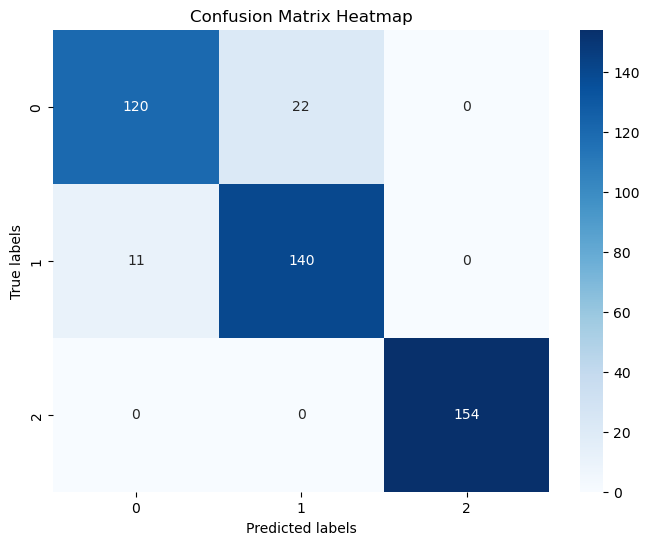

In [ ]:
# generate confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=catboost_model.classes_,
    yticklabels=catboost_model.classes_,
)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [ ]:
# to improve the accuracy of the model, I used the weights for the classes for my model
# calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_encoded), y=y_train_encoded
)

# create a dictionary of class weights
class_weights_dict = dict(zip(np.unique(y_train_encoded), class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.0469483568075117, 1: 0.9878183831672204, 2: 0.9685124864277959}


In [ ]:
# initialize CatBoost model with class weights
catboost_model_with_weights = CatBoostClassifier(
    iterations=500,  # number of boosting iterations
    depth=6,  # depth of trees
    learning_rate=0.1,  # learning rate
    loss_function="MultiClass",  # multiClass loss for multi-class classification
    eval_metric="Accuracy",  # we use accuracy as the evaluation metric
    verbose=100,  # print logs every 100 iterations
    random_seed=42,  # ensure reproducibility
    class_weights=class_weights_dict,  # adjust class weights
)

# fit the model
catboost_model_with_weights.fit(X_train, y_train_encoded)

# predict on the test set
y_pred_with_weights = catboost_model_with_weights.predict(X_test)

0:	learn: 0.8648032	total: 197ms	remaining: 1m 38s
100:	learn: 0.9550540	total: 19.2s	remaining: 1m 15s
200:	learn: 0.9965783	total: 39.7s	remaining: 59.1s
300:	learn: 1.0000000	total: 54.6s	remaining: 36.1s
400:	learn: 1.0000000	total: 1m 7s	remaining: 16.8s
499:	learn: 1.0000000	total: 1m 23s	remaining: 0us


In [ ]:
y_pred_prob_with_weights = catboost_model_with_weights.predict_proba(X_test)

# print the classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_with_weights))

# print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_with_weights))

# calculate ROC-AUC for each class (One-vs-Rest)
roc_auc_with_weights = roc_auc_score(y_test_encoded, y_pred_prob_with_weights, multi_class="ovr")
print(f"\nROC-AUC: {roc_auc_with_weights}")

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       142
           1       0.87      0.93      0.90       151
           2       1.00      1.00      1.00       154

    accuracy                           0.93       447
   macro avg       0.93      0.93      0.93       447
weighted avg       0.93      0.93      0.93       447

Confusion Matrix:
[[121  21   0]
 [ 11 140   0]
 [  0   0 154]]

ROC-AUC: 0.9835422557734445


<h2>Sectoral Similarity Analysis</h2>

In [85]:
industrials = pd.read_csv("./data/stock_sectors/industrials.csv")

In [86]:
industrials_ticker_list = industrials["Symbol"].tolist()
industrials_data = yfinance.download(industrials_ticker_list, start="2005-01-01")
industrials_data_open = industrials_data[["Open"]]
industrials_data_open.columns = [
    "_".join(col) for col in industrials_data_open.columns
]  # MultiIndex to SingleIndex
industrials_data_monthly_mom = (
    industrials_data["Open"].resample("ME").last().pct_change() + 1
)

[*********************100%***********************]  668 of 668 completed

5 Failed downloads:
['MOG.B', 'WSO.B', 'HEI.A', 'MOG.A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['UHAL.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2005-01-01 -> 2025-02-16)')
C:\Users\Beyza\AppData\Local\Temp\ipykernel_31140\2777360661.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  industrials_data["Open"].resample("ME").last().pct_change() + 1


In [88]:
industrials_data_monthly_mom.to_csv(
    "./data/data_monthly/industrials_data_monthly_mom.csv"
)

In [89]:
i_data = pd.read_csv("./data/data_monthly/industrials_data_monthly_mom.csv")

In [90]:
# turn date into a column
i_data = i_data.reset_index(drop="True")

# turn ticker names into rows
i_data = i_data.melt(id_vars=["Date"], var_name="Ticker", value_name="Open")
i_data

,Date,Ticker,Open
0,2005-01-31,AAL,NaN
1,2005-02-28,AAL,NaN
2,2005-03-31,AAL,NaN
3,2005-04-30,AAL,NaN
4,2005-05-31,AAL,NaN
...,...,...,...
161651,2024-10-31,ZWS,1.018602
161652,2024-11-30,ZWS,1.109366
161653,2024-12-31,ZWS,0.939250
161654,2025-01-31,ZWS,1.043652


In [91]:
# check for empty values
print(i_data.isna().sum())

Date          0
Ticker        0
Open      56152
dtype: int64


In [92]:
# delete rows that contain empty values
i_data = i_data.dropna()

# check if empty values are deleted
print(i_data.isna().sum())
i_data

Date      0
Ticker    0
Open      0
dtype: int64


,Date,Ticker,Open
9,2005-10-31,AAL,1.184600
10,2005-11-30,AAL,1.370833
11,2005-12-31,AAL,1.141337
12,2006-01-31,AAL,0.776831
13,2006-02-28,AAL,1.141584
...,...,...,...
161651,2024-10-31,ZWS,1.018602
161652,2024-11-30,ZWS,1.109366
161653,2024-12-31,ZWS,0.939250
161654,2025-01-31,ZWS,1.043652


In [122]:
i_data_features = extract_features(i_data, column_id='Ticker', column_sort='Date', 
                                       default_fc_parameters=ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


In [123]:
i_data_features.columns

Index(['Open__variance_larger_than_standard_deviation',
       'Open__has_duplicate_max', 'Open__has_duplicate_min',
       'Open__has_duplicate', 'Open__sum_values', 'Open__abs_energy',
       'Open__mean_abs_change', 'Open__mean_change',
       'Open__mean_second_derivative_central', 'Open__median',
       ...
       'Open__fourier_entropy__bins_5', 'Open__fourier_entropy__bins_10',
       'Open__fourier_entropy__bins_100',
       'Open__permutation_entropy__dimension_3__tau_1',
       'Open__permutation_entropy__dimension_4__tau_1',
       'Open__permutation_entropy__dimension_5__tau_1',
       'Open__permutation_entropy__dimension_6__tau_1',
       'Open__permutation_entropy__dimension_7__tau_1',
       'Open__query_similarity_count__query_None__threshold_0.0',
       'Open__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

In [124]:
i_data_features.head()

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
AAL,0.0,0.0,0.0,0.0,236.713323,248.588738,0.189178,-0.001080,-0.000464,1.005141,...,1.075932,1.710529,3.679146,1.766093,3.099118,4.454555,5.196687,5.376094,NaN,1.608968
AAON,0.0,0.0,0.0,0.0,246.270670,253.600349,0.101263,-0.000304,-0.000149,1.013566,...,1.157720,1.781495,3.677883,1.787261,3.141242,4.503209,5.279517,5.435989,NaN,1.230109
ABM,0.0,0.0,0.0,0.0,243.349675,247.378229,0.087299,-0.000072,-0.000073,1.016038,...,1.261559,1.891817,3.843045,1.788519,3.149333,4.506736,5.259677,5.435989,NaN,1.234134
ACA,0.0,0.0,0.0,0.0,76.638372,78.807788,0.100025,-0.000927,-0.000261,1.021228,...,0.769307,1.297834,2.962323,1.762995,3.002259,3.876960,4.189083,4.234107,NaN,1.159299
ACCO,0.0,0.0,0.0,0.0,236.849568,248.975460,0.163966,-0.000435,0.000380,1.009963,...,0.366307,0.946170,2.992456,1.781705,3.091793,4.452845,5.223327,5.411105,NaN,1.721162


In [125]:
i_data_features.to_csv("./data/training/i_data_features.csv")

In [201]:
i_features = pd.read_csv("./data/training/i_data_features.csv")

In [202]:
i_features

,Unnamed: 0,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
0,AAL,0.0,0.0,0.0,0.0,236.713323,248.588738,0.189178,-0.001080,-0.000464,...,1.075932,1.710529,3.679146,1.766093,3.099118,4.454555,5.196687,5.376094,NaN,1.608968
1,AAON,0.0,0.0,0.0,0.0,246.270670,253.600349,0.101263,-0.000304,-0.000149,...,1.157720,1.781495,3.677883,1.787261,3.141242,4.503209,5.279517,5.435989,NaN,1.230109
2,ABM,0.0,0.0,0.0,0.0,243.349675,247.378229,0.087299,-0.000072,-0.000073,...,1.261559,1.891817,3.843045,1.788519,3.149333,4.506736,5.259677,5.435989,NaN,1.234134
3,ACA,0.0,0.0,0.0,0.0,76.638372,78.807788,0.100025,-0.000927,-0.000261,...,0.769307,1.297834,2.962323,1.762995,3.002259,3.876960,4.189083,4.234107,NaN,1.159299
4,ACCO,0.0,0.0,0.0,0.0,236.849568,248.975460,0.163966,-0.000435,0.000380,...,0.366307,0.946170,2.992456,1.781705,3.091793,4.452845,5.223327,5.411105,NaN,1.721162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,ZIP,0.0,0.0,0.0,0.0,44.400855,44.495035,0.143481,-0.001303,0.002202,...,1.093507,1.650224,2.954673,1.773637,2.837745,3.544512,3.688879,3.663562,NaN,1.193151
655,ZJK,0.0,0.0,0.0,0.0,5.516192,6.323057,0.284378,0.029433,-0.065093,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,NaN,NaN,NaN,NaN
656,ZONE,0.0,0.0,0.0,0.0,9.173065,8.615205,0.193937,0.022427,0.018974,...,1.329661,1.329661,1.791759,1.732868,1.945910,1.791759,1.609438,1.386294,NaN,0.985556
657,ZTO,0.0,0.0,0.0,0.0,100.824540,102.775887,0.117691,0.001354,0.001172,...,1.030080,1.680069,3.335525,1.765611,3.013339,3.993805,4.431628,4.528547,NaN,1.224028


In [ ]:
i_features.rename(columns={"Unnamed: 0": "Company"}, inplace=True)

# Display the first few rows to confirm the change
i_features

,Company,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
0,AAL,0.0,0.0,0.0,0.0,236.713323,248.588738,0.189178,-0.001080,-0.000464,...,1.075932,1.710529,3.679146,1.766093,3.099118,4.454555,5.196687,5.376094,NaN,1.608968
1,AAON,0.0,0.0,0.0,0.0,246.270670,253.600349,0.101263,-0.000304,-0.000149,...,1.157720,1.781495,3.677883,1.787261,3.141242,4.503209,5.279517,5.435989,NaN,1.230109
2,ABM,0.0,0.0,0.0,0.0,243.349675,247.378229,0.087299,-0.000072,-0.000073,...,1.261559,1.891817,3.843045,1.788519,3.149333,4.506736,5.259677,5.435989,NaN,1.234134
3,ACA,0.0,0.0,0.0,0.0,76.638372,78.807788,0.100025,-0.000927,-0.000261,...,0.769307,1.297834,2.962323,1.762995,3.002259,3.876960,4.189083,4.234107,NaN,1.159299
4,ACCO,0.0,0.0,0.0,0.0,236.849568,248.975460,0.163966,-0.000435,0.000380,...,0.366307,0.946170,2.992456,1.781705,3.091793,4.452845,5.223327,5.411105,NaN,1.721162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,ZIP,0.0,0.0,0.0,0.0,44.400855,44.495035,0.143481,-0.001303,0.002202,...,1.093507,1.650224,2.954673,1.773637,2.837745,3.544512,3.688879,3.663562,NaN,1.193151
655,ZJK,0.0,0.0,0.0,0.0,5.516192,6.323057,0.284378,0.029433,-0.065093,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,NaN,NaN,NaN,NaN
656,ZONE,0.0,0.0,0.0,0.0,9.173065,8.615205,0.193937,0.022427,0.018974,...,1.329661,1.329661,1.791759,1.732868,1.945910,1.791759,1.609438,1.386294,NaN,0.985556
657,ZTO,0.0,0.0,0.0,0.0,100.824540,102.775887,0.117691,0.001354,0.001172,...,1.030080,1.680069,3.335525,1.765611,3.013339,3.993805,4.431628,4.528547,NaN,1.224028


In [204]:
# Temporarily assign a placeholder value ("I") for company names
i_features["Company"] = "I"  # Replace all company names with "I"
i_features

,Company,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
0,I,0.0,0.0,0.0,0.0,236.713323,248.588738,0.189178,-0.001080,-0.000464,...,1.075932,1.710529,3.679146,1.766093,3.099118,4.454555,5.196687,5.376094,NaN,1.608968
1,I,0.0,0.0,0.0,0.0,246.270670,253.600349,0.101263,-0.000304,-0.000149,...,1.157720,1.781495,3.677883,1.787261,3.141242,4.503209,5.279517,5.435989,NaN,1.230109
2,I,0.0,0.0,0.0,0.0,243.349675,247.378229,0.087299,-0.000072,-0.000073,...,1.261559,1.891817,3.843045,1.788519,3.149333,4.506736,5.259677,5.435989,NaN,1.234134
3,I,0.0,0.0,0.0,0.0,76.638372,78.807788,0.100025,-0.000927,-0.000261,...,0.769307,1.297834,2.962323,1.762995,3.002259,3.876960,4.189083,4.234107,NaN,1.159299
4,I,0.0,0.0,0.0,0.0,236.849568,248.975460,0.163966,-0.000435,0.000380,...,0.366307,0.946170,2.992456,1.781705,3.091793,4.452845,5.223327,5.411105,NaN,1.721162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,I,0.0,0.0,0.0,0.0,44.400855,44.495035,0.143481,-0.001303,0.002202,...,1.093507,1.650224,2.954673,1.773637,2.837745,3.544512,3.688879,3.663562,NaN,1.193151
655,I,0.0,0.0,0.0,0.0,5.516192,6.323057,0.284378,0.029433,-0.065093,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,NaN,NaN,NaN,NaN
656,I,0.0,0.0,0.0,0.0,9.173065,8.615205,0.193937,0.022427,0.018974,...,1.329661,1.329661,1.791759,1.732868,1.945910,1.791759,1.609438,1.386294,NaN,0.985556
657,I,0.0,0.0,0.0,0.0,100.824540,102.775887,0.117691,0.001354,0.001172,...,1.030080,1.680069,3.335525,1.765611,3.013339,3.993805,4.431628,4.528547,NaN,1.224028


In [ ]:
# separate target variable and properties
X_i = i_features.drop(columns=["Company"], errors="ignore")
y_i = i_features["Company"]

In [ ]:
# clear non-numeric columns
X_i = X_i.select_dtypes(include=[np.number])

In [ ]:
# check and remove infinite and extremely large values
X_i.replace([np.inf, -np.inf], np.nan, inplace=True)

In [208]:
print(X_i.isna().sum().sum())  # Count total NaN values

86720


In [ ]:
# fill empty values with median
X_i = X_i.fillna(X_i.median())

In [210]:
print(X_i.isna().sum().sum())  # Total NaN values


659


In [211]:
# one column still has NaN values
print(X_i.isna().sum())  # NaN count per column

Open__variance_larger_than_standard_deviation                0
Open__has_duplicate_max                                      0
Open__has_duplicate_min                                      0
Open__has_duplicate                                          0
Open__sum_values                                             0
                                                          ... 
Open__permutation_entropy__dimension_5__tau_1                0
Open__permutation_entropy__dimension_6__tau_1                0
Open__permutation_entropy__dimension_7__tau_1                0
Open__query_similarity_count__query_None__threshold_0.0    659
Open__mean_n_absolute_max__number_of_maxima_7                0
Length: 783, dtype: int64


In [212]:
# this shows that entire column is NaN
print(X_i["Open__query_similarity_count__query_None__threshold_0.0"].isna().sum())

659


In [214]:
# Fill NaN values with 0, and assign it back to the column to avoid the FutureWarning
X_i["Open__query_similarity_count__query_None__threshold_0.0"] = X_i[
    "Open__query_similarity_count__query_None__threshold_0.0"
].fillna(0)

In [215]:
X_scaled_i = scaler.fit_transform(X_i)

In [216]:
y_encoded_i = label_encoder.fit_transform(y_i)

# Split dataset
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_scaled_i,
    y_encoded_i,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded_i,  # Now, all classes have at least 2 members
)

In [221]:
# Predict probabilities for sector similarity
proba_i = catboost_model_with_weights.predict_proba(X_test_i)

In [225]:
# Check the shape of proba_i
print(f"Shape of proba_i: {proba_i.shape}")

# Assuming that there are 3 industries (H, T, F), define the labels for the industries
industry_labels = ["H", "T", "F"]

# Convert probabilities to a DataFrame with appropriate column names
proba_df_i = pd.DataFrame(proba_i, columns=industry_labels)

# Show top companies with their most similar industry
proba_df_i["Most_Similar_Industry"] = proba_df_i.idxmax(axis=1)

# Display the results (show top 10 most similar industries for the companies)
print(proba_df_i[["Most_Similar_Industry"]].head(10))

Shape of proba_i: (132, 3)
  Most_Similar_Industry
0                     T
1                     T
2                     H
3                     H
4                     H
5                     T
6                     H
7                     T
8                     H
9                     H


In [243]:
proba_df_i

,H,T,F,Most_Similar_Industry,Company
0,0.171853,0.822028,0.006119,T,AAL
1,0.055744,0.942367,0.001888,T,AAON
2,0.830607,0.165899,0.003494,H,ABM
3,0.940064,0.058546,0.001390,H,ACA
4,0.696660,0.300690,0.002650,H,ACCO
...,...,...,...,...,...
127,0.672466,0.314548,0.012986,H,CMRE
128,0.268183,0.727454,0.004363,T,CNH
129,0.259558,0.712593,0.027850,T,CNI
130,0.587054,0.407527,0.005419,H,CNM


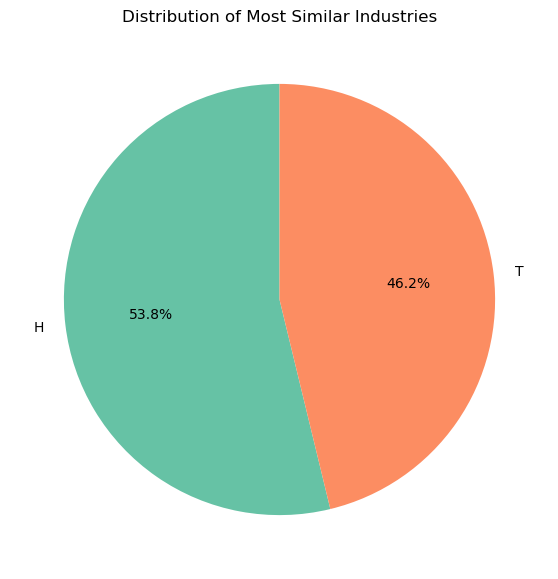

In [240]:
# Count the most similar industries
industry_counts = proba_df_i["Most_Similar_Industry"].value_counts()

# Plot pie chart
plt.figure(figsize=(7, 7))
industry_counts.plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set2", len(industry_counts)),
)
plt.title("Distribution of Most Similar Industries")
plt.ylabel("")
plt.show()